In [1]:
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn                     # neural networks

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import time

import plotly.graph_objects as go

# Ecuación de Transporte
Sea $(x,t) \in \Omega = [-5,5]\times [0,3]$. Determinar $u(t,x)$ que satisfaga: 

1. $$u_t + c\, u_x  = 0 \hspace{0.8cm}  \text{en el interior de } \Omega,$$

2. $$u(x, 0) = f(x)  \hspace{0.8cm}  \text{en } [-5,5],$$

<!--  3. $$ \dfrac{\partial u}{\partial t} = g(t) \hspace{0.8cm}  \text{en } [0,1],$$ -->

donde $c$ es una constante positiva.

## Problema. 

Resuelva la ecuacion de transporte para $c=2$ y  $f(x) = \dfrac{1}{1 + x^2}$

## Funciones Auxiliares

In [2]:
#Graficos 3D
def plot3D_Matrix(x,t,y):
    X,T= x,t
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('u(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T, X, F_xt,cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u(x,t)')
    plt.show()

## Generación del dominio

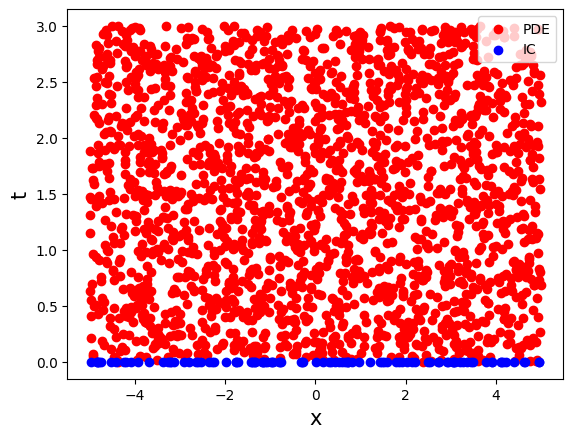

In [3]:
x_min = -5.0
x_max = 5.0
t_min = 0.0
t_max = 3.0

# Puntos colocacion PDE
N_f = 2000
x_data = x_min + (x_max - x_min) * torch.rand(N_f) 
t_data = t_min + (t_max - t_min) * torch.rand(N_f)

x_data = x_data.float().reshape(-1,1)
t_data = t_data.float().reshape(-1,1)

x_data.requires_grad = True
t_data.requires_grad = True

# Initial condition
N_u = 100

x_init = x_min + (x_max - x_min) * torch.rand(N_u)
t_init = t_min * torch.ones(N_u)

x_init = x_init.float().reshape(-1,1)
t_init = t_init.float().reshape(-1,1)

# Puntos de Entrenamiento
plt.scatter(x_data.detach().numpy(), t_data.detach().numpy() , color = 'r', label = 'PDE')
plt.scatter(x_init.detach().numpy(), t_init.detach().numpy() , color = 'b', label = 'IC')
plt.xlabel('x', fontsize = 15)
plt.ylabel('t', fontsize = 15)
plt.legend()
plt.show()

In [10]:
class Trans_Net(nn.Module):
    def __init__(self):
        super(Trans_Net, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        ) 

        #self.c = nn.Parameter(torch.tensor(2.0))

        self.c = torch.tensor(1.0)

        self.loss_function = nn.MSELoss(reduction ='mean')

        self.iter = 0
        
        self.loss_hist = {'loss':[], 'pde_loss':[], 'ic_loss':[]}

    def forward(self, x, t):
        X = torch.cat([x, t], 1)
        return self.layers(X)
    
    def loss_PDE(self, x, t):
        u = self.forward(x,t)
        u_x = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_t = autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return self.loss_function(u_t, - self.c * u_x)
    
    def loss_IC(self, x, t):
        return self.loss_function(self.forward(x,t), 1/(1 + x**2 ))
    
    def loss(self, x_c, t_c, x_i, t_i):
        loss_pde = self.loss_PDE(x_c, t_c)
        loss_ic = self.loss_IC(x_i, t_i)
        loss = loss_pde + loss_ic
        return loss, loss_pde, loss_ic

    def train(self, x_c, t_c, x_i, t_i, epochs = 1000, lr = 0.001, steps = 10000):

        # Adam Optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr)

        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss, loss_pde, loss_ic = self.loss(x_c, t_c, x_i, t_i)
            loss.backward()
            optimizer.step()
            
            self.loss_hist['loss'].append(loss.item())
            self.loss_hist['pde_loss'].append(loss_pde.item())
            self.loss_hist['ic_loss'].append(loss_ic.item())

        print("Starting optimization with L-BFGS")

        # L-BFGS Optimizer
        def closure():
            optimizer.zero_grad()
            loss, loss_pde, loss_ic = self.loss(x_c, t_c, x_i, t_i)
            loss.backward()
            self.loss_hist['loss'].append(loss.item())
            self.loss_hist['pde_loss'].append(loss_pde.item())
            self.loss_hist['ic_loss'].append(loss_ic.item())
            return loss

        optimizer = torch.optim.LBFGS(self.parameters(), lr=0.1,
                              max_iter = steps,
                              max_eval = None,
                              tolerance_grad = 1e-11,
                              tolerance_change = 1e-11,
                              history_size = 100,
                              line_search_fn = 'strong_wolfe')

        # Optimización
        start_time = time.time()
        optimizer.step(closure)  # Directamente usando self.closure
        elapsed = time.time() - start_time
        print('Finish: Training time L-BFGS: %.2f' % elapsed)
        
    

In [11]:
Net = Trans_Net()
Net.train(x_data, t_data, x_init, t_init)

  0%|          | 0/1000 [00:00<?, ?it/s]

Starting optimization with L-BFGS
Finish: Training time L-BFGS: 2.97


## Resultados

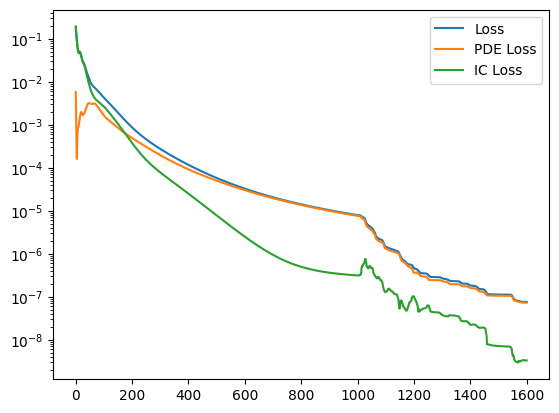

In [12]:
# Gráfica Loss
plt.plot(Net.loss_hist['loss'], label = 'Loss')
plt.plot(Net.loss_hist['pde_loss'], label = 'PDE Loss')
plt.plot(Net.loss_hist['ic_loss'], label = 'IC Loss')
plt.yscale('log')
plt.legend()
plt.show()

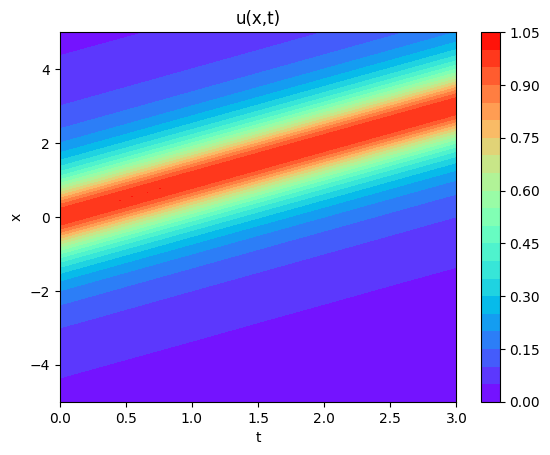

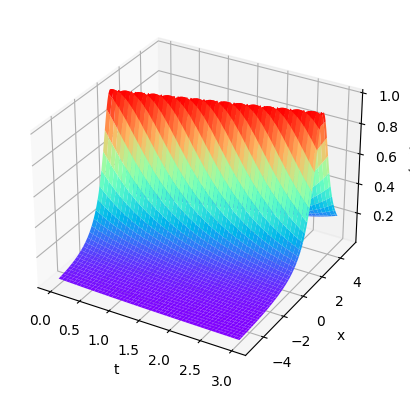

In [13]:
# plot prediccion
N_t = 100
x_test, t_test = np.meshgrid(np.linspace(x_min, x_max, N_t), np.linspace(t_min, t_max, N_t))
x_test_ = torch.tensor(x_test.flatten()).clone().detach().view(-1, 1).float()
t_test_ = torch.tensor(t_test.flatten()).clone().detach().view(-1, 1).float()

u_pred = Net(x_test_, t_test_).detach().numpy().reshape(N_t, N_t)

plot3D_Matrix(x_test,t_test,u_pred)